# Assignment 9

Use data from `https://github.com/thedenaas/hse_seminars/tree/master/2018/seminar_13/data.zip`  
Implement model in pytorch from "An Unsupervised Neural Attention Model for Aspect Extraction, He et al, 2017", also desribed in seminar notes.  

You can use sentence embeddings with attention **[7 points]**:  
$z_s = \sum_{i}^n \alpha_i e_{w_i}, z_s \in R^d$ sentence embedding  
$\alpha_i = softmax(d_i)$  attention weight for i-th token  
$d_i = e_{w_i}^T M y_s$ attention with trainable matrix $M \in R^{dxd}$  
$y_s = \frac 1 n \sum_{i=1}^n e_{w_i}, y_s \in R^d$ sentence context  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  

**Or** just use sentence embedding as an average over word embeddings **[5 points]**:  
$z_s = \frac 1 n \sum_{i=1}^n e_{w_i}, z_s \in R^d$ sentence embedding  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  
 
$p_t = softmax(W z_s + b), p_t \in R^K$ topic weights for sentence $s$, with trainable matrix $W \in R^{dxK}$ and bias vector $b \in R^K$  
$r_s = T^T p_t, r_s \in R^d$ reconstructed sentence embedding as a weighted sum of topic embeddings   
$T \in R^{Kxd}$ trainable matrix of topic embeddings, K=number of topics


**Training objective**:
$$ J = \sum_{s \in D} \sum_{i=1}^n max(0, 1-r_s^T z_s + r_s^T n_i) + \lambda ||T^T T - I ||^2_F  $$
where   
$m$ random sentences are sampled as negative examples from dataset $D$ for each sentence $s$  
$n_i = \frac 1 n \sum_{i=j}^n e_{w_j}$ average of word embeddings in the i-th sentence  
$||T^T T - I ||_F$ regularizer, that enforces matrix $T$ to be orthogonal  
$||A||^2_F = \sum_{i=1}^N\sum_{j=1}^M a_{ij}^2, A \in R^{NxM}$ Frobenius norm


**[3 points]** Compute topic coherence for at least for 3 different number of topics. Use 10 nearest words for each topic. It means you have to train one model for each number of topics. You can use code from seminar notes with word2vec similarity scores.

In [1]:
import pandas as pd
import numpy as np

import nltk
import spacy 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import Vectors
from gensim.models import Word2Vec, KeyedVectors

nltk.download('punkt')
spacy_en = spacy.load('en')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
BATCH_SIZE = 512
NEG_SAMPLES = 3  # number of negative samples
random_state = 23
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Making DataFrame 

In [0]:
!wget -O data.zip https://github.com/thedenaas/hse_seminars/blob/master/2018/seminar_13/data.zip?raw=true
!unzip '/content/data.zip'

In [0]:
with open('/content/data.txt', 'r') as f:
    data = nltk.tokenize.sent_tokenize(f.read())

with open('/content/stopwords.txt', 'r') as f:
    stopwords = f.read().splitlines()

In [5]:
print(len(data), data[0])
print(len(stopwords), stopwords[0])

183400 Barclays' defiance of US fines has merit Barclays disgraced itself in many ways during the pre-financial crisis boom years.
350 a


In [0]:
def create_df(texts, neg_samples):
    """
    Creating pandas DataFrame from texts and adding randomly chosen negative samples
    """
    df = pd.DataFrame()
    df['text'] = texts

    for i in range(1, neg_samples+1):
        df['neg_{}'.format(i)] = [texts[ind] if ind != el else texts[23] for el, ind in enumerate(np.random.choice(np.arange(0,len(texts)), size=len(texts)))]
    return df

In [0]:
df = create_df(data, neg_samples=NEG_SAMPLES)

In [8]:
df.head()

,text,neg_1,neg_2,neg_3
0,Barclays' defiance of US fines has merit Barcl...,"He hated the work, but always had a shine on h...",Just like he shouldn’t have his finger on the ...,The has always beaten the fair pay drum loudly...
1,"So it is tempting to think the bank, when aske...",“Cromwell had two daughters and a son.,It’s essential that they should be able to fin...,The Trump Organization denied allegations of f...
2,"That is not the view of the chief executive, J...",“It’s not hard to imagine a future dystopia wh...,"Yesterday, Jeremy Corbyn said he would not sup...",Prize is not for resale.
3,Barclays thinks the DoJ’s claims are “disconne...,It’s not life-threatening; it just hurts a lot...,"They had a daughter, Billie.",Donald Trump is starting down the barrel of an...
4,"But actually, some grudging respect for Staley...",For a man who began his musical life as a rapp...,Everything about what has happened since seems...,"Worse, the only way the app specifies which ca..."


In [0]:
df.to_csv('data.csv', index=False)

# Dataset and Iterator

In [0]:
def tokenize(text):
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

In [11]:
# Using data to pretrain word-embeddings

data_tokenized = list(df['text'].apply(lambda x: tokenize(x)))
model = Word2Vec(data_tokenized, size=200, window=10, negative=5)  # building emb of size 200 (parameters from the paper)
model_weights = torch.FloatTensor(model.wv.vectors)
model.wv.save_word2vec_format('pretrained_embeddings')
vectors = Vectors(name='pretrained_embeddings', cache='./')  # and saving the weights to build vocab later

 98%|█████████▊| 23761/24240 [00:02<00:00, 10372.36it/s]


In [0]:
TEXT = Field(sequential=True, 
             include_lengths=False, 
             batch_first=True, 
             tokenize=tokenize, 
             lower=True, 
             stop_words=stopwords)

dataset = TabularDataset(
           path="/content/data.csv",
           format='csv',
           skip_header=True,
           fields=[('text', TEXT),('neg_1', TEXT), ('neg_2', TEXT), ('neg_3', TEXT)])

TEXT.build_vocab(dataset, vectors=vectors, min_freq = 2,
                   unk_init = torch.Tensor.normal_)

In [0]:
vocab = TEXT.vocab

In [17]:
print('Vocab size:', len(TEXT.vocab.itos))

Vocab size: 55976


In [0]:
train, test = dataset.split(0.8)
train, valid = train.split(0.8)

In [0]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    shuffle=True,
    sort_key=lambda x: len(x.text),
    device=device
)

# Model

In [0]:
class MyModel(nn.Module):

    def __init__(self, vocab_size, embed_size, topics_size):
        super(MyModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.topics_size = topics_size

        self.embeddings = nn.Embedding(self.vocab_size, self.embed_size)
        self.embeddings.weight.data.copy_(vocab.vectors)
        self.embeddings.requires_grad = False

        self.fc1 = nn.Linear(self.embed_size, self.topics_size)  # W
        self.fc2 = nn.Linear(self.topics_size, self.embed_size)  # T


    def sentence_embeddings(self, x):
        '''
        input: (batch_size, seq_length, embed_size)
        output: (batch_size, embed_size)
        '''
        x = torch.sum(x, dim=1)/x.size()[1]
        return x

    
    def forward(self, batch):
        
        text, neg_1, neg_2, neg_3 = batch.text, batch.neg_1, batch.neg_2, batch.neg_3

        text_true = self.sentence_embeddings(self.embeddings(text))
        neg_1 = self.sentence_embeddings(self.embeddings(neg_1))
        neg_2 = self.sentence_embeddings(self.embeddings(neg_2))
        neg_3 = self.sentence_embeddings(self.embeddings(neg_3))

        
        text_out = self.fc1(text_true)
        text_out = F.softmax(text_out, dim=1)
        text_out = self.fc2(text_out)

        return text_true, text_out, neg_1, neg_2, neg_3

**Training objective**:
$$ J = \sum_{s \in D} \sum_{i=1}^n max(0, 1-r_s^T z_s + r_s^T n_i) + \lambda ||T^T T - I ||^2_F  $$
where   
$m$ random sentences are sampled as negative examples from dataset $D$ for each sentence $s$  
$n_i = \frac 1 n \sum_{i=j}^n e_{w_j}$ average of word embeddings in the i-th sentence  
$||T^T T - I ||_F$ regularizer, that enforces matrix $T$ to be orthogonal  
$||A||^2_F = \sum_{i=1}^N\sum_{j=1}^M a_{ij}^2, A \in R^{NxM}$ Frobenius norm

In [0]:
# https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

class LossFunction(nn.Module):

    def __init__(self):
        super(LossFunction, self).__init__()

    def forward(self, emb_true, emb_pred, n1, n2, n3, T, lambd=1):
        loss_batch = 0
        for ind, e_true in enumerate(emb_true):
            temp = 1 - torch.dot(emb_pred[ind].T, e_true) + torch.dot(emb_pred[ind].T, n1[ind]) + torch.dot(emb_pred[ind].T, n2[ind]) + torch.dot(emb_pred[ind].T, n3[ind])
            t_max = F.relu(temp)
            loss_batch += t_max
        loss_batch += lambd * torch.norm(torch.mm(T.T, T) - torch.eye(T.size()[1], T.size(1)).to(device))
        return loss_batch / BATCH_SIZE

In [0]:
train_losses = []
valid_losses = []

def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        text_true, text_out, neg_1, neg_2, neg_3 = model(batch)
        loss = criterion(text_true, text_out, neg_1, neg_2, neg_3, model.fc2.weight)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        
        train_losses.append(curr_loss)
        iterator.set_postfix(loss='%.5f' % curr_loss)

    return running_loss


def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            text_true, text_out, neg_1, neg_2, neg_3 = model(batch)
            loss = criterion(text_true, text_out, neg_1, neg_2, neg_3, model.fc2.weight)
            epoch_loss += loss.data.item()
            valid_losses.append(loss)

    return epoch_loss / n_batches


def nn_train(model, train_iterator, valid_iterator, optimizer, criterion, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, criterion,  epoch)
        valid_loss = _test_epoch(model, valid_iterator, criterion)

        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)

# Topic CoHerence

Compute topic coherence for at least for 3 different number of topics. Use 10 nearest words for each topic. It means you have to train one model for each number of topics. You can use code from seminar notes with word2vec similarity scores.

In [0]:
topic_models = []

In [0]:
def get_descriptor(terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

## Topic coherence for 5 topics

In [26]:
model_5 = MyModel(vocab_size=len(vocab), embed_size=200, topics_size=5)
model_5.to(device)
optimizer_5 = optim.Adam(model_5.parameters())
criterion_5 = LossFunction()
criterion_5.to(device)

LossFunction()

In [27]:
train_losses = []
valid_losses = []
nn_train(model_5, train_iterator, valid_iterator, optimizer_5, criterion_5, n_epochs=5)


validation loss 0.11663



validation loss 0.08702



validation loss 0.06578



validation loss 0.05730



validation loss 0.05078


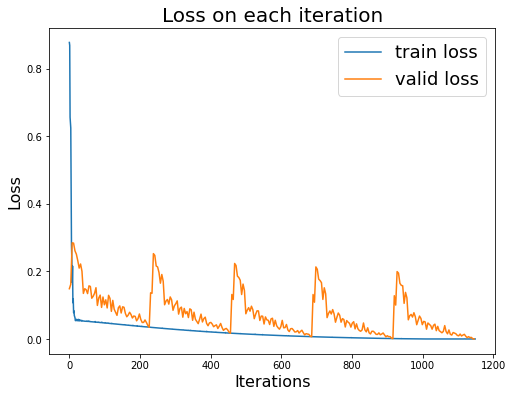

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [0]:
H = model_5.fc1.weight.cpu().detach().numpy()
W  = torch.mm(model_5.embeddings.weight, model_5.fc2.weight).cpu().detach().numpy()
k = 5

topic_models.append( (k,W,H) )

In [30]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor(vocab.itos, H, topic_index, 10 ) )
    str_descriptor = ", ".join(descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: post, face, market, right, remain, suggest, try, candidate, london, rate
Topic 02: lot, write, director, back, ask, goal, little, offer, something, ﻿1
Topic 03: top, speak, feel, care, start, night, expect, debate, family, claim
Topic 04: leave, set, tell, top, low, point, hold, pay, really, question
Topic 05: part, go, i, close, home, eu, move, clinton, meet, rate


## Topic coherence for 10 topics

In [31]:
model_10 = MyModel(vocab_size=len(vocab), embed_size=200, topics_size=10)
model_10.to(device)
optimizer_10 = optim.Adam(model_10.parameters())
criterion_10 = LossFunction()
criterion_10.to(device)

LossFunction()

In [32]:
train_losses = []
valid_losses = []
nn_train(model_10, train_iterator, valid_iterator, optimizer_10, criterion_10, n_epochs=5)


validation loss 0.12413



validation loss 0.08506



validation loss 0.06644



validation loss 0.05414



validation loss 0.05230


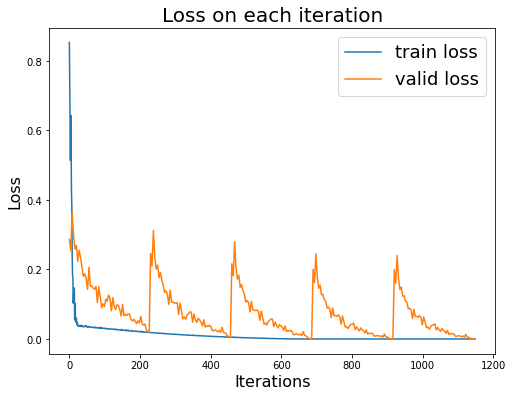

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [0]:
H = model_10.fc1.weight.cpu().detach().numpy()
W  = torch.mm(model_10.embeddings.weight, model_10.fc2.weight).cpu().detach().numpy()
k = 10

topic_models.append( (k,W,H) )

In [35]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor(vocab.itos, H, topic_index, 10 ) )
    str_descriptor = ", ".join(descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: take, hard, claim, director, away, european, help, feel, world, political
Topic 02: market, game, question, fund, live, way, face, business, set, young
Topic 03: campaign, find, love, leader, open, house, team, week, election, result
Topic 04: way, public, party, business, doe, director, david, win, policy, far
Topic 05: today, long, white, plan, look, time, love, record, government, support
Topic 06: clear, film, team, lose, <pad>, news, eu, long, uk, song
Topic 07: minister, show, hold, people, story, party, public, point, old, ﻿1
Topic 08: work, give, really, post, <unk>, family, head, low, remain, right
Topic 09: song, turn, fall, player, show, today, fund, leader, london, united
Topic 10: service, clinton, london, clear, hard, uk, lot, away, half, election


## Topic coherence for 15 topics

In [36]:
model_15 = MyModel(vocab_size=len(vocab), embed_size=200, topics_size=15)
model_15.to(device)
optimizer_15 = optim.Adam(model_15.parameters())
criterion_15 = LossFunction()
criterion_15.to(device)

LossFunction()

In [37]:
train_losses = []
valid_losses = []
nn_train(model_15, train_iterator, valid_iterator, optimizer_15, criterion_15, n_epochs=5)


validation loss 0.06154



validation loss 0.03436



validation loss 0.02597



validation loss 0.02414



validation loss 0.02272


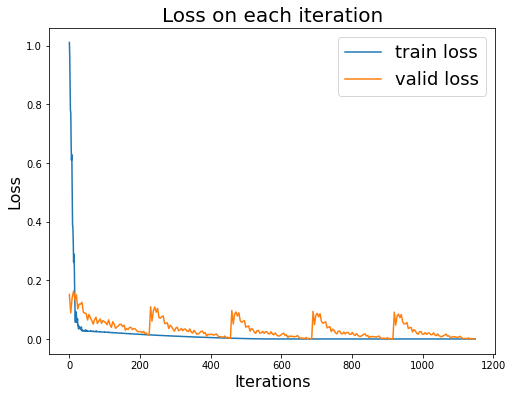

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses)), valid_losses)
plt.legend(('train loss', 'valid loss'),prop={'size': 18})
plt.title('Loss on each iteration', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [0]:
H = model_15.fc1.weight.cpu().detach().numpy()
W  = torch.mm(model_15.embeddings.weight, model_15.fc2.weight).cpu().detach().numpy()
k = 15

topic_models.append( (k,W,H) )

In [40]:
descriptors = []
for topic_index in range(k):
    descriptors.append(get_descriptor(vocab.itos, H, topic_index, 10 ) )
    str_descriptor = ", ".join(descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: need, report, time, ask, film, financial, europe, follow, british, country
Topic 02: part, fall, need, hard, david, offer, away, group, week, 2
Topic 03: season, term, brexit, world, white, clinton, way, political, hold, home
Topic 04: london, help, talk, 2, job, market, policy, pay, music, fund
Topic 05: feel, business, clinton, life, political, share, election, i, uk, trump
Topic 06: member, home, win, part, service, term, candidate, cameron, try, star
Topic 07: financial, expect, show, hold, point, season, party, market, group, speak
Topic 08: offer, state, change, little, support, president, man, back, <unk>, issue
Topic 09: hard, night, europe, player, term, keep, season, song, bring, pay
Topic 10: world, clear, song, debate, place, close, share, city, attack, good
Topic 11: britain, game, policy, show, expect, take, tell, service, place, meet
Topic 12: top, ask, back, time, change, release, problem, issue, financial, part
Topic 13: share, claim, live, group, meet, win, 

## End of block

In [41]:
from itertools import combinations


def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            try:
                pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
            except:
                pass
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor(vocab.itos, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append(calculate_coherence(model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=05: Coherence=0.1185
K=10: Coherence=0.0854
K=15: Coherence=0.1076
